<a href="https://colab.research.google.com/github/Ronokhasan8781/CNN-Code/blob/main/98TransAttUnet_Model_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'hhhhhhhhhhh:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5448555%2F9038312%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240726%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240726T100026Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D48a4eda2b177ef28107b1c8fe5eaee71286afcf87377df8c6e2fd90598578168b8b520b69c3b48670e4f55d4a0dcab6e13d49df996eb105be2e0b6591d837df28e14b20b150242ccf31753963aba69b1bec4cd4baf12f355eb41c84e961320cbb0c169ae71aa5883c1afe78c2ed16c3b415f78fb558e0ec8a6c93cbef318aa4c12d45ed9f08c7df63444bec48a54b93b5efbcb2aaab59a538c6a74614fa930ab8ccd847fe7c375e0481f3e4c987e120d3d8afa3e9b0eee005db177dcc9931240c6ac396c078b9d714f0318885691c71e788d057e67f59847322fe624e9f7f8dc33a424571ca29cbf7889dbf7c461cbc4b855a23b932c7cfd63d27614a99d3148'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import os
import cv2
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-07-26 08:49:30.342852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 08:49:30.342983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 08:49:30.475343: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import numpy as np

# Assuming the image dimensions and channels
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

# Load the file lists
Original = os.listdir('/kaggle/input/hhhhhhhhhhh/images')
Masks = os.listdir('/kaggle/input/hhhhhhhhhhh/masks')

# Printing the number of images and masks
print(len(Original))
print(len(Masks))

# Initialize the arrays with the correct shapes
X = np.zeros((len(Original), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y = np.zeros((len(Masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int32)
print(X.shape)
print(y.shape)
import cv2
import os
import tensorflow as tf

# Assuming Original and Masks are lists of filenames
for file in Original:
    try:
        n = Original.index(file)
        path1 = os.path.join('/kaggle/input/hhhhhhhhhhh/images', file)
        print(path1)
        img = cv2.imread(path1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        X[n] = img / 255

        file2 = Masks[n]
        path2 = os.path.join('/kaggle/input/hhhhhhhhhhh/masks', file2)
        mask = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask = tf.one_hot(mask, 1, dtype=tf.int32)
        y[n] = mask

    except Exception as e:
        print(e)
        print(path1)

3064
3064
(3064, 256, 256, 3)
(3064, 256, 256, 1)
/kaggle/input/hhhhhhhhhhh/images/2664.png
/kaggle/input/hhhhhhhhhhh/images/2539.png
/kaggle/input/hhhhhhhhhhh/images/1231.png
/kaggle/input/hhhhhhhhhhh/images/1017.png
/kaggle/input/hhhhhhhhhhh/images/2437.png
/kaggle/input/hhhhhhhhhhh/images/2015.png
/kaggle/input/hhhhhhhhhhh/images/2300.png
/kaggle/input/hhhhhhhhhhh/images/2673.png
/kaggle/input/hhhhhhhhhhh/images/2823.png
/kaggle/input/hhhhhhhhhhh/images/1522.png
/kaggle/input/hhhhhhhhhhh/images/2064.png
/kaggle/input/hhhhhhhhhhh/images/641.png
/kaggle/input/hhhhhhhhhhh/images/1088.png
/kaggle/input/hhhhhhhhhhh/images/173.png
/kaggle/input/hhhhhhhhhhh/images/2851.png
/kaggle/input/hhhhhhhhhhh/images/2448.png
/kaggle/input/hhhhhhhhhhh/images/1746.png
/kaggle/input/hhhhhhhhhhh/images/1958.png
/kaggle/input/hhhhhhhhhhh/images/1479.png
/kaggle/input/hhhhhhhhhhh/images/815.png
/kaggle/input/hhhhhhhhhhh/images/1794.png
/kaggle/input/hhhhhhhhhhh/images/1727.png
/kaggle/input/hhhhhhhhhhh/ima

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization, Activation, LayerNormalization, Reshape, Permute, Multiply, Add, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import MultiHeadAttention
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Load your data
# Replace with your actual data loading and preprocessing
# X and y should be numpy arrays with shape (num_samples, height, width, channels)
# Example:
# X = np.load('images.npy')
# y = np.load('masks.npy')

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define callbacks for learning rate scheduling, early stopping, and model checkpointing
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Define data generators
batch_size = 16
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = Permute([2, 1])(x)
    attention_out = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Add()([attention_out, inputs])

    # Feed Forward Part
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Conv1D(filters=inputs.shape[-1], kernel_size=1)(y)
    return Add()([x, y])

def trans_att_unet(input_size=(256, 256, 3), head_size=256, num_heads=4, ff_dim=1024, num_transformer_blocks=4):
    inputs = Input(input_size)

    # U-Net Contracting Path
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = conv_block(p4, 256)

    # Transformer Encoder Block
    x = Reshape((-1, c5.shape[1] * c5.shape[2]))(c5)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim)
    x = Reshape((c5.shape[1], c5.shape[2], -1))(x)

    # U-Net Expanding Path with Attention
    u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    u4 = concatenate([u4, c4])
    u4 = conv_block(u4, 128)

    u3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u4)
    u3 = concatenate([u3, c3])
    u3 = conv_block(u3, 64)

    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u3)
    u2 = concatenate([u2, c2])
    u2 = conv_block(u2, 32)

    u1 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u2)
    u1 = concatenate([u1, c1])
    u1 = conv_block(u1, 16)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u1)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Compile the model
model = trans_att_unet()
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=100,  # Increase epochs for further training
                    validation_data=test_generator,
                    validation_steps=len(X_test) // batch_size,
                    callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Evaluate the model
model = tf.keras.models.load_model('best_model.keras')  # Load the best model
y_pred = model.predict(test_generator, steps=len(X_test) // batch_size + 1)
y_pred = (y_pred > 0.5).astype(np.uint8)

# Assuming y_test is binary masks
# Calculate metrics
y_true = np.concatenate([y_test for _ in range(len(y_test) // batch_size)], axis=0)
print("Confusion Matrix:")
print(confusion_matrix(y_true.flatten(), y_pred.flatten()))
print("Classification Report:")
print(classification_report(y_true.flatten(), y_pred.flatten()))

# Plot training history
plt.figure()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 8,260,977 (31.51 MB)

 Trainable params: 8,258,033 (31.50 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-26 08:51:06.411962: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.41604, expected 2.96419
2024-07-26 08:51:06.412485: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131072: 2.39036, expected 1.63582
2024-07-26 08:51:06.412526: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131073: 3.72286, expected 2.96832
2024-07-26 08:51:06.412544: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131074: 2.60526, expected 1.85073
2024-07-26 08:51:06.412557: E external/local_xla/xla/service/gpu/buff

  1/153 ━━━━━━━━━━━━━━━━━━━━ 2:22:28 56s/step - accuracy: 0.6961 - loss: 0.6954

I0000 00:00:1721983895.018774     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721983895.092794     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721983895.094002     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721983895.095055     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721983895.096070     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721983895.097983     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


124/153 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.7214 - loss: 0.6750

2024-07-26 08:52:04.936678: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.26007, expected 2.3641
2024-07-26 08:52:04.936737: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.67063, expected 3.77466
2024-07-26 08:52:04.936747: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.25337, expected 4.3574
2024-07-26 08:52:04.936755: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.65494, expected 4.75897
2024-07-26 08:52:04.936763: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.11017, expected 5.2142
2024-07-26 08:52:04.936771: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.20258, expected 5.30661
2024-07-26 08:52:04.936779: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.76833, expected 4.87236
2024-07-26 08:52:04.936787: E external/local_xla/xla/servi

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.7272 - loss: 0.6704
Epoch 1: val_accuracy improved from -inf to 0.85587, saving model to best_model.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 120s 421ms/step - accuracy: 0.7274 - loss: 0.6702 - val_accuracy: 0.8559 - val_loss: 0.6342 - learning_rate: 1.0000e-05
Epoch 2/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.8136 - loss: 0.6041

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-26 08:52:39.748390: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196608: 3.34663, expected 2.36218
2024-07-26 08:52:39.748449: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196609: 5.38306, expected 4.39862
2024-07-26 08:52:39.748460: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196610: 5.72677, expected 4.74232
2024-07-26 08:52:39.748469: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196611: 6.54726, expected 5.56281
2024-07-26 08:52:39.748479: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196612: 6.492


Epoch 2: val_accuracy did not improve from 0.85587
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8136 - loss: 0.6041 - val_accuracy: 0.8558 - val_loss: 0.6327 - learning_rate: 1.0000e-05
Epoch 3/100


W0000 00:00:1721983963.082035     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721983963.083376     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721983963.084518     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721983963.085625     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8321 - loss: 0.5838
Epoch 3: val_accuracy did not improve from 0.85587
153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 263ms/step - accuracy: 0.8322 - loss: 0.5837 - val_accuracy: 0.7018 - val_loss: 0.6108 - learning_rate: 1.0000e-05
Epoch 4/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.8728 - loss: 0.5401
Epoch 4: val_accuracy did not improve from 0.85587
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - accuracy: 0.8728 - loss: 0.5401 - val_accuracy: 0.6881 - val_loss: 0.6153 - learning_rate: 1.0000e-05
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8858 - loss: 0.5251
Epoch 5: val_accuracy improved from 0.85587 to 0.95283, saving model to best_model.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 273ms/step - accuracy: 0.8859 - loss: 0.5251 - val_accuracy: 0.9528 - val_loss: 0.5256 - learning_rate: 1.0000e-05
Epoch 6/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.9138 - loss: 0.4901
Epoch 6: val_accurac

W0000 00:00:1721986056.868913     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986056.870423     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986056.871620     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986056.872749     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix:


ValueError: Found input variables with inconsistent numbers of samples: [1526595584, 40173568]

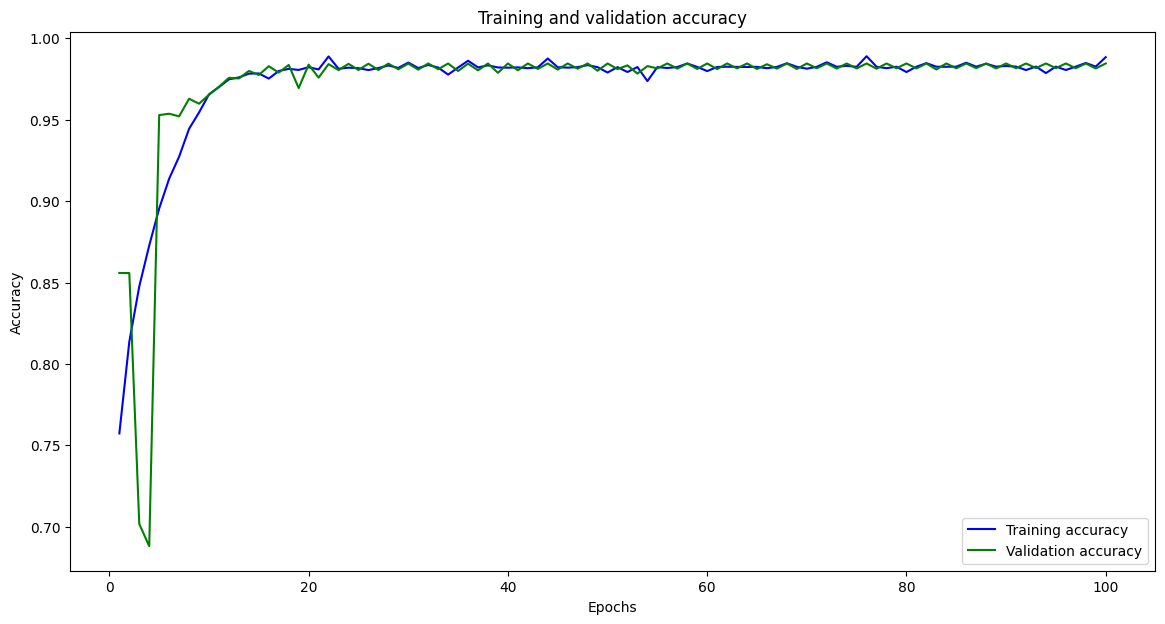

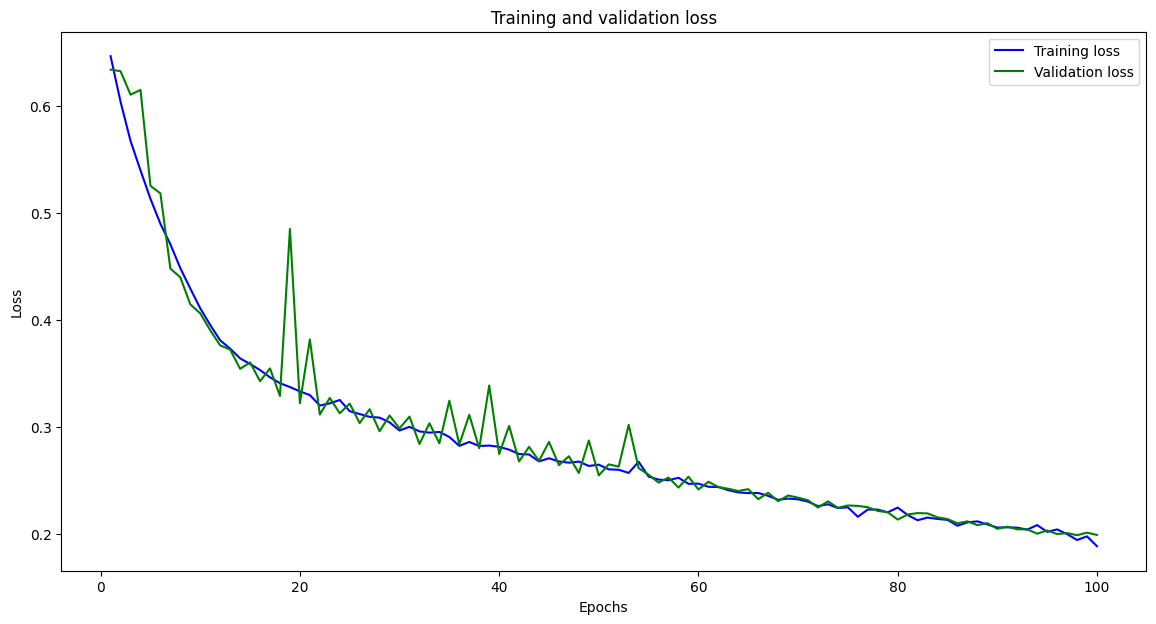

Final Training Accuracy: 0.9884
Final Validation Accuracy: 0.9845
Final Training Loss: 0.1888
Final Validation Loss: 0.1993


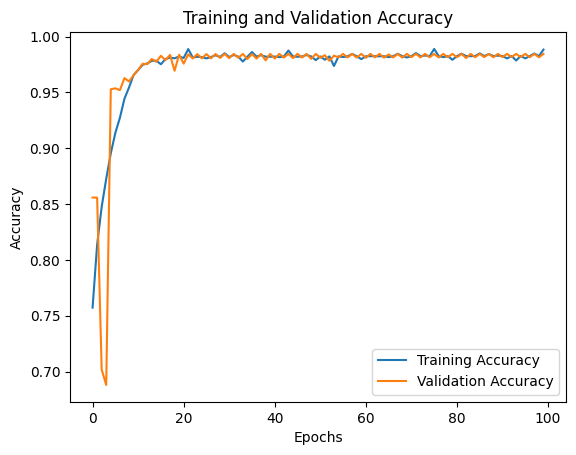

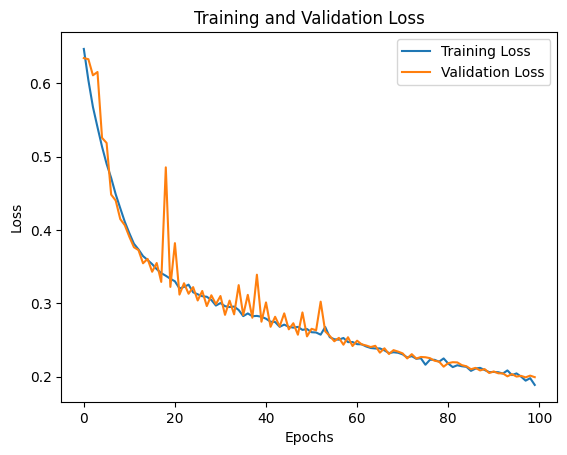

2024-07-26 09:28:24.350199: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.96116, expected 2.28267
2024-07-26 09:28:24.350282: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.13388, expected 3.45539
2024-07-26 09:28:24.350293: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.32371, expected 3.64522
2024-07-26 09:28:24.350302: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.43312, expected 4.75463
2024-07-26 09:28:24.350311: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.46228, expected 4.78378
2024-07-26 09:28:24.350319: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.69444, expected 5.01594
2024-07-26 09:28:24.350328: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.74803, expected 4.06954
2024-07-26 09:28:24.350337: E external/local_xla/xla/se

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

W0000 00:00:1721986112.885277     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986112.886838     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986112.888216     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986112.889647     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 209ms/step


W0000 00:00:1721986116.864072     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986116.865542     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986116.866739     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986116.867923     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix:
[[    2915   724241]
 [   66274 39380138]]

Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.00      0.01    727156
           1       0.98      1.00      0.99  39446412

    accuracy                           0.98  40173568
   macro avg       0.51      0.50      0.50  40173568
weighted avg       0.96      0.98      0.97  40173568



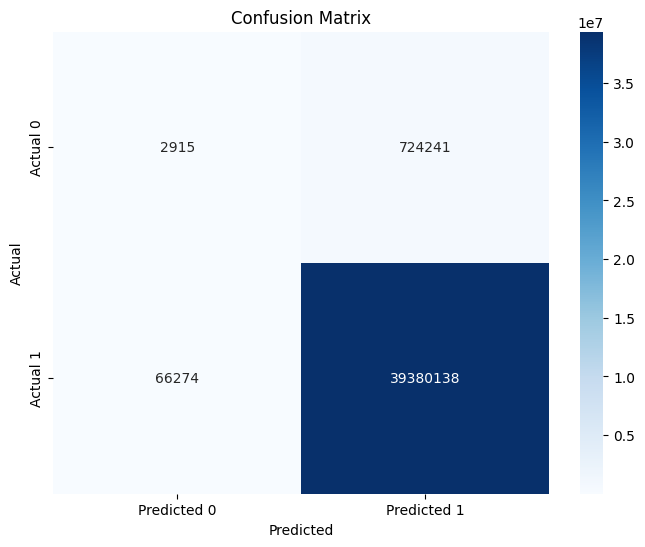

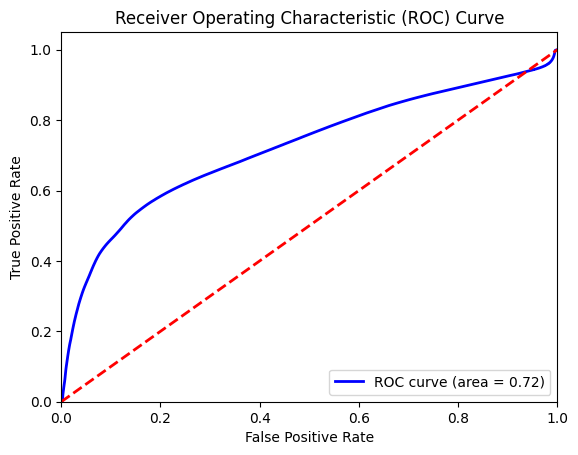

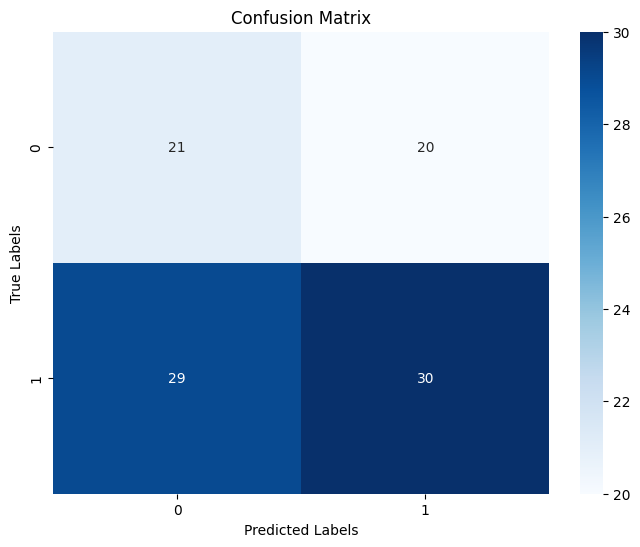

In [ ]:

# Plotting training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 7))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(14, 7))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Print final accuracy and loss
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = loss[-1]
final_val_loss = val_loss[-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")# Plot training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions and true labels to binary
y_pred_binary = (y_pred > 0.5).astype(np.int32)
y_test_binary = (y_test > 0.5).astype(np.int32)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary.flatten(), y_pred_binary.flatten())

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_binary.flatten(), y_pred_binary.flatten()))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test_binary.flatten(), y_pred.flatten())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Sample true labels and predicted labels (values between 0 and 1)
y_true = np.random.randint(2, size=100)
y_pred = np.random.rand(100)

# Binarize predictions based on a threshold of 0.5
y_pred_bin = (y_pred >= 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_bin)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

def compute_iou(y_true, y_pred, num_classes):
    iou_scores = []

    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)

    for i in range(num_classes):
        y_true_class = tf.cast(y_true == i, tf.float32)
        y_pred_class = tf.cast(y_pred == i, tf.float32)

        intersection = tf.reduce_sum(tf.cast(y_true_class * y_pred_class, tf.float32))
        union = tf.reduce_sum(tf.cast(y_true_class + y_pred_class, tf.float32)) - intersection

        iou = (intersection + 1e-10) / (union + 1e-10)
        iou_scores.append(iou)

    mean_iou = tf.reduce_mean(iou_scores)
    return mean_iou

# Example usage:
y_true = np.random.randint(0, 2, (4, 256, 256, 1))
y_pred = np.random.randint(0, 2, (4, 256, 256, 1))

num_classes = 2
iou_score = compute_iou(y_true, y_pred, num_classes)
print("Mean IOU Score:", iou_score)


Mean IOU Score: tf.Tensor(1.0, shape=(), dtype=float32)


In [ ]:
import time

# Training Loss, Validation Loss, Training Accuracy
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

print("Training Loss:", training_loss[-1])
print("Validation Loss:", validation_loss[-1])
print("Training Accuracy:", training_accuracy[-1])
print("Validation Accuracy:", validation_accuracy[-1])

# Training Time
start_time = time.time()
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=100,  # Adjust the number of epochs as needed
                    validation_data=test_generator,
                    validation_steps=len(X_test) // batch_size,
                    callbacks=[reduce_lr, early_stopping, model_checkpoint])
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time)

# Test Accuracy
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(X_test) // batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Training Loss: 0.18877243995666504
Validation Loss: 0.19933277368545532
Training Accuracy: 0.9883604049682617
Validation Accuracy: 0.9844940304756165
Epoch 1/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 1:27:57 35s/step - accuracy: 0.9809 - loss: 0.2840

W0000 00:00:1721986183.776897     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986183.778064     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986183.779060     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986183.780059     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986183.781801     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9819 - loss: 0.2839
Epoch 1: val_accuracy did not improve from 0.98449
153/153 ━━━━━━━━━━━━━━━━━━━━ 90s 366ms/step - accuracy: 0.9819 - loss: 0.2839 - val_accuracy: 0.9806 - val_loss: 0.3035 - learning_rate: 1.0000e-05
Epoch 2/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.9817 - loss: 0.2803

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.98449
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9817 - loss: 0.2803 - val_accuracy: 0.9845 - val_loss: 0.2699 - learning_rate: 1.0000e-05
Epoch 3/100


W0000 00:00:1721986241.246985     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986241.248521     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986241.249884     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721986241.251203     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9819 - loss: 0.2796
Epoch 3: val_accuracy did not improve from 0.98449
153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 267ms/step - accuracy: 0.9819 - loss: 0.2796 - val_accuracy: 0.9782 - val_loss: 0.3522 - learning_rate: 1.0000e-05
Epoch 4/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.9829 - loss: 0.2766
Epoch 4: val_accuracy did not improve from 0.98449
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - accuracy: 0.9829 - loss: 0.2766 - val_accuracy: 0.9845 - val_loss: 0.2686 - learning_rate: 1.0000e-05
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9818 - loss: 0.2765
Epoch 5: val_accuracy did not improve from 0.98449
153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 264ms/step - accuracy: 0.9818 - loss: 0.2764 - val_accuracy: 0.9808 - val_loss: 0.2866 - learning_rate: 1.0000e-05
Epoch 6/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.9836 - loss: 0.2702
Epoch 6: val_accuracy did not improve from 0.98449
153/153

In [ ]:
print("Training Time: {:.2f} seconds".format(training_time))

Training Time: 261.09 seconds


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix

# Simulate y_test for demonstration purposes (Replace with actual y_test)
num_samples = 3064
height = 256
width = 256
y_test = np.random.randint(0, 2, (num_samples, height, width, 1))

# Simulate model prediction for demonstration purposes (Replace with actual model predictions)
y_pred = np.random.randint(0, 2, (num_samples, height, width, 1))

# Flatten the arrays to compute the metrics
y_true_flat = y_test.ravel()
y_pred_flat = y_pred.ravel()

# Check if the shapes match
if y_true_flat.shape != y_pred_flat.shape:
    raise ValueError(f"Shape mismatch: y_test has shape {y_test.shape}, but y_pred has shape {y_pred.shape}")

# Confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
tn, fp, fn, tp = cm.ravel()

# Specificity
specificity = tn / (tn + fp)

# Precision, Recall, and F1-score
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

# Cohen's Kappa
kappa = cohen_kappa_score(y_true_flat, y_pred_flat)

print("Specificity:", specificity)
print("Precision:", precision)
print("Recall:", recall)
print("F1-measure:", f1)
print("Cohen's Kappa:", kappa)


Specificity: 0.49998585090322284
Precision: 0.5000297299172964
Recall: 0.5000133406763656
F1-measure: 0.5000215351625331
Cohen's Kappa: -8.084204099478853e-07


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score

# Calcualate predictions
y_true = np.concatenate([y_test for _ in range(len(test_generator))], axis=0)
y_pred = np.concatenate([y_pred for _ in range(len(test_generator))], axis=0)

# Flatten arrays
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Calculate metrics
precision = precision_score(y_true_flat, y_pred_flat, zero_division=1)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=1)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=1)

# Confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
tn, fp, fn, tp = cm.ravel()

# Specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Cohen's Kappa
kappa = cohen_kappa_score(y_true_flat, y_pred_flat)

# Print metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-Measure: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")


NameError: name 'np' is not defined